In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
plt.close('all')
plt.rc('text', usetex=False)
# plt.rc('font', family='serif')
LEGEND_FONT_SIZE = 12
AXIS_FONT_SIZE = 10
TICKS_FONT_SIZE = 10
TITLE_FONT_SIZE = 12
linewidth=2.0
lw=1.2
current_palette = sns.color_palette()

matplotlib.rcParams["xtick.labelsize"] = TICKS_FONT_SIZE

In [3]:
data = pd.read_csv("listings.csv", low_memory=False) 

In [4]:
len(data)

20025

In [5]:
print(", ".join(data.columns))

id, listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_m

In [6]:
kept_columns = ["host_is_superhost", 'latitude','longitude', "accommodates", 
                "bathrooms", "bedrooms", "price", "number_of_reviews",
                "review_scores_rating", "instant_bookable"]

response = "price"
covariates = [c for c in kept_columns if c != response]

In [7]:
data = data[kept_columns]

In [8]:
data.head()

,host_is_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,price,number_of_reviews,review_scores_rating,instant_bookable
0,t,52.36575,4.94142,2,1.5,1.0,$59.00,277,98.0,t
1,f,52.36509,4.89354,2,1.0,1.0,$80.00,306,89.0,f
2,f,52.37297,4.88339,3,1.0,1.0,$125.00,3,100.0,f
3,t,52.38673,4.89208,2,1.0,1.0,$155.00,206,99.0,t
4,t,52.36719,4.89092,2,1.0,1.0,$75.00,318,98.0,f


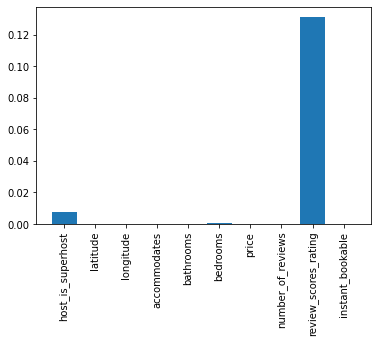

In [9]:
## for each column, check the percentage of NAs

nas = np.zeros(len(kept_columns))
for i, k in enumerate(kept_columns):
    nas[i] = data[k].isna().sum() / len(data)
    
plt.bar(kept_columns, nas)
plt.xticks(rotation=90)
plt.show()

In [10]:
## and drop the NAs
data = data.dropna()

In [11]:
#convert prices to float
def convert_to_float(value):
    # remove ","
    string = value[1:].replace(",","")
    return float(string)

data['price'] = data['price'].apply(lambda x: convert_to_float(x))

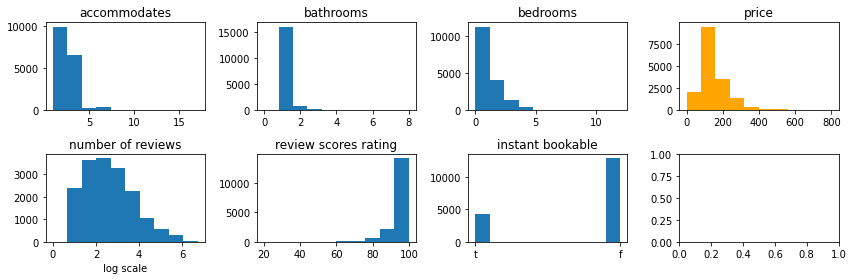

In [12]:
numeric_variables = ["accommodates", "bathrooms", "bedrooms", "price", 
                     "number_of_reviews", "review_scores_rating", "instant_bookable"]

in_log_scale = ["number_of_reviews"]

fig, axes = plt.subplots(2, 4, figsize=(12, 4))
axes = axes.flat

for i, k in enumerate(numeric_variables):
    if k == "price":
        axes[i].hist(data[k].values, range=(0, 800), color="orange")
    elif k in in_log_scale:
        axes[i].hist(np.log(data[k].values+1))
        axes[i].set_xlabel("log scale")
    else:
        axes[i].hist(data[k].values)
    axes[i].set_title(" ".join(k.split("_")), fontsize=TITLE_FONT_SIZE)
    
    
    
plt.tight_layout()
plt.show()

# plot neighbourhoods
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood',s=20, data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [13]:
import geopandas as gpd

In [14]:
#load geojson
geodf = gpd.read_file('neighbourhoods.geojson')


## Find correspondence between locations and geojson neigh

In [15]:
#Create a point of each Airbnb location, and enable the "data" dataframe into a geopandas dataframe
datageom = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

#Now, do a spatial join... This code here runs an intersect analysis to find which neighborhood the Airbnb location is in
joined = gpd.sjoin(geodf, datageom, how='inner', op='intersects')
#N.B. some data are removed if not in any polygon

#Rename the column. 
joined.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

#Drop the second geometry column
joined.drop(columns='geometry', inplace=True)

/home/riccardo/.local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


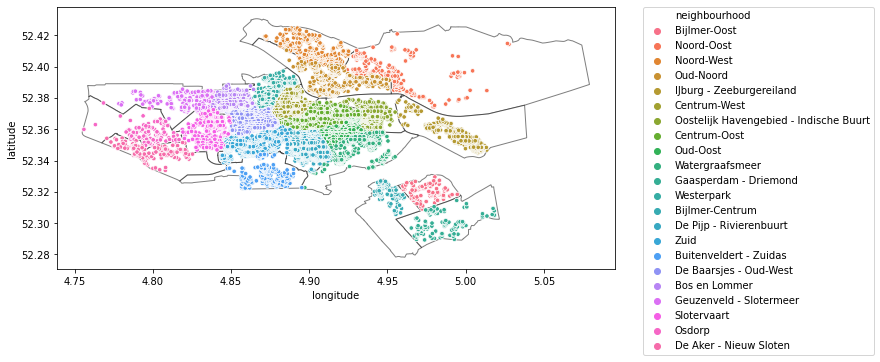

In [16]:
# plot neighbourhoods
fig,ax1 = plt.subplots(1,1, figsize=(10,10))
base = geodf.plot(color='white',alpha=0.5, edgecolor='black', ax=ax1)
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood',s=20, data=joined)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [17]:
#Create a count of each neighborhood
nb_join_count = joined.groupby('neighbourhood').agg('count').reset_index()

#Get the "true count". Join this data to the original neighborhoods geometry 
true_count = geodf.merge(nb_join_count, on='neighbourhood')
true_count['price'] = np.log(true_count['price'])
#

## Plot count

In [18]:
import contextily as ctx

west, south, east, north = (
    4.75594,
    52.28927,
    5.05769,
    52.45471
             )


ghent_img, ghent_ext = ctx.bounds2img(west, 
                                     south, 
                                     east, 
                                     north, 
                                     ll=True, 
                                     source=ctx.providers.Stamen.Terrain
                                    )

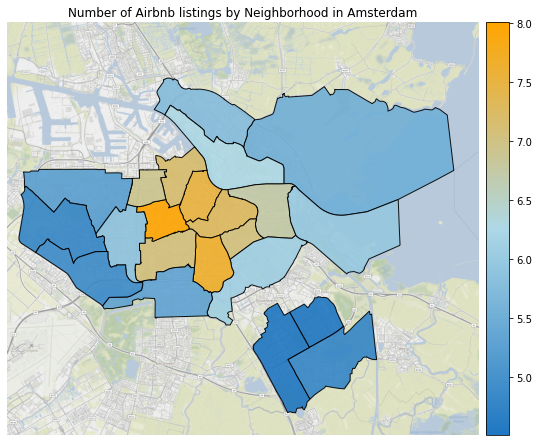

In [19]:
## Plot count
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   ((0., 0.122, 0.122), 
                   (0.5, 0.6784313725490196, 0.6784313725490196),
                   (1, 1.0, 1.0)),

         'green': ((0, 0.467, 0.467), 
                   (0.5, 0.8470588235294118, 0.8470588235294118),
                   (1, 0.6470588235294118, 0.6470588235294118)),

         'blue':  ((0, 0.76, 0.76), 
                   (0.5, 0.9019607843137255, 0.9019607843137255),
                   (1, .0, .0)),
          }

newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

#Lets plot number of observations in each area
fig,ax = plt.subplots(1,1, figsize=(9, 9))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

im = ax.imshow(ghent_img, extent=ghent_ext, alpha=0.7)

true_count = true_count.to_crs(epsg=3857)

true_count.plot(column='price', cmap=newcmp, ax=ax, edgecolor='black', linewidth=1,
                legend=True, cax=cax, alpha=0.9)

ax.set_title('Number of Airbnb listings by Neighborhood in Amsterdam', loc='center')
ax.set_axis_off()
plt.savefig('count_by_neigh.png', bbox_inches="tight")
plt.show()

## Plot Mean and Std

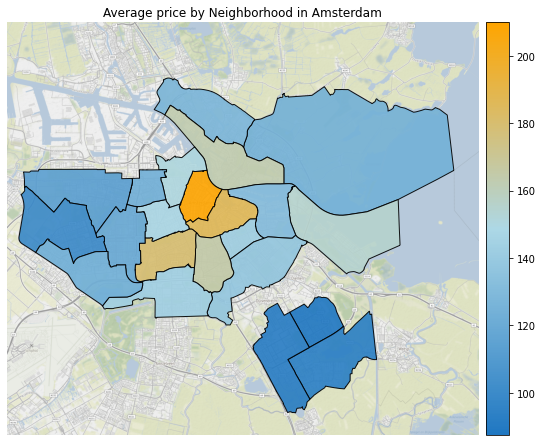

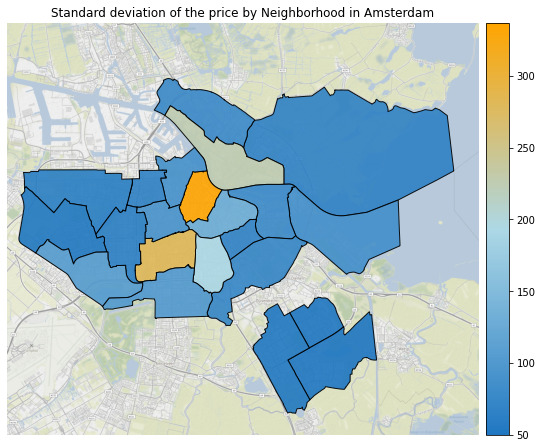

In [20]:
nb_join_mean = joined.groupby('neighbourhood').agg('mean').reset_index()
mean_neigh = geodf.merge(nb_join_mean, on='neighbourhood')

nb_join_std = joined.groupby('neighbourhood').agg('std').reset_index()
std_neigh = geodf.merge(nb_join_std, on='neighbourhood')


fig,ax = plt.subplots(1,1, figsize=(9, 9))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

im = ax.imshow(ghent_img, extent=ghent_ext, alpha=0.7)

mean_neigh = mean_neigh.to_crs(epsg=3857)

mean_neigh.plot(column='price', cmap=newcmp, ax=ax, edgecolor='black', linewidth=1,
                legend=True, cax=cax, alpha=0.9)

ax.set_title('Average price by Neighborhood in Amsterdam', loc='center')
ax.set_axis_off()
plt.savefig('mean_by_neigh.png', bbox_inches="tight")
plt.show()



fig,ax = plt.subplots(1,1, figsize=(9, 9))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

im = ax.imshow(ghent_img, extent=ghent_ext, alpha=0.7)

std_neigh = std_neigh.to_crs(epsg=3857)

std_neigh.plot(column='price', cmap=newcmp, ax=ax, edgecolor='black', linewidth=1,
                legend=True, cax=cax, alpha=0.9)

ax.set_title('Standard deviation of the price by Neighborhood in Amsterdam', loc='center')
ax.set_axis_off()
plt.savefig('std_by_neigh.png', bbox_inches="tight")
plt.show()

# Standardize numerical covariates

In [21]:
from scipy.stats import boxcox, probplot, norm

12.098639706372628


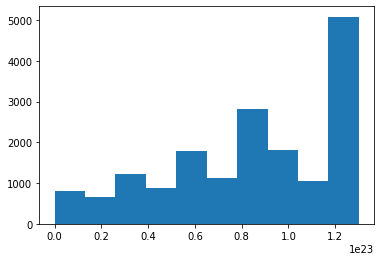

In [22]:
x_t, param = boxcox(joined.review_scores_rating)
print(param)
plt.hist(x_t)
plt.show()
joined.loc[:, "review_scores_rating"] = x_t

In [23]:
standardized = joined

for col in ["accommodates", "bathrooms", "bedrooms", "number_of_reviews", "review_scores_rating"]:
    mean = joined.loc[:, col].mean()
    std = joined.loc[:, col].std()
    standardized.loc[:, col] -= mean
    standardized.loc[:, col] /= std

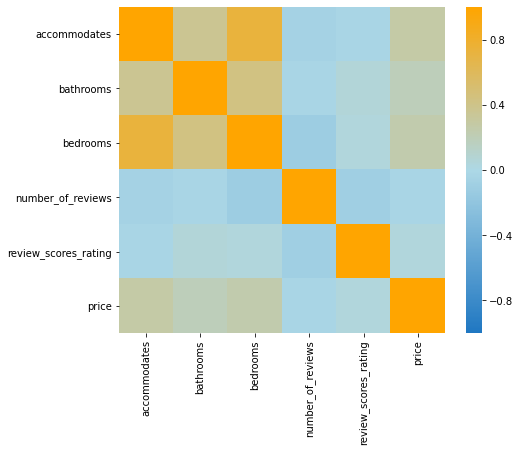

In [24]:
import seaborn as sns

numerics = ["accommodates", "bathrooms", "bedrooms", 
            "number_of_reviews", "review_scores_rating", "price"]

corr_dataframe = standardized[numerics]
f, ax = plt.subplots(figsize=(7.5, 6))
corr = corr_dataframe.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=newcmp,
            square=True, ax=ax, vmin=-1, vmax=1)
plt.savefig('corr_matrix.png', bbox_inches="tight")

plt.show()

In [25]:
# convert data to list of lists
grouped_price = standardized.groupby(['neighbourhood']).apply(lambda x: x['price'].values.tolist())
grouped_cov = standardized.groupby(['neighbourhood']).apply(lambda x: x[covariates].values.tolist())
neigh = grouped_cov.index.values

price = []
cov = []
low = 1
up = 1000
for index, value in grouped_price.items():
    p = np.array(value)
    bound_indices = np.where(np.logical_and(p<up, p>low))[0]
    price.append(p[bound_indices])
    cov.append(pd.DataFrame(data=np.array(grouped_cov[index])[bound_indices],
                            columns=covariates))

# PLOT AREAS DENSITY COMPARISON

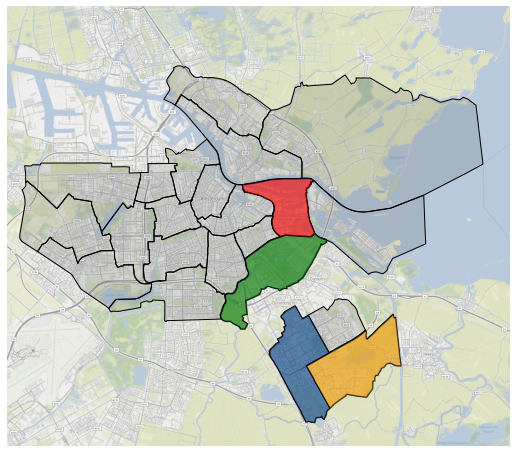

In [38]:
import seaborn


indices = [0, 9, 19, 14]
palettes_by_neigh = [
    np.array(sns.color_palette("Blues", 10).as_hex())[np.array([3, 6, 9])],
    np.array(sns.light_palette("orange", 10).as_hex())[np.array([3, 6, 9])],
    np.array(sns.light_palette("green", 10).as_hex())[np.array([3, 6, 9])],
    np.array(sns.light_palette("red", 10).as_hex())[np.array([3, 6, 9])]
]

fig,ax = plt.subplots(1,1, figsize=(9, 9))
im = ax.imshow(ghent_img, extent=ghent_ext, alpha=0.7)
geodf = geodf.to_crs(epsg=3857)
ax = geodf.plot(fc=(0,0,0,0.1), edgecolor='black', ax=ax)
for i in range(len(indices)):
    ax = geodf.iloc[np.where(geodf['neighbourhood']==neigh[indices[i]])[0],:].plot(
        color=palettes_by_neigh[i][-1], alpha=0.6, edgecolor='black', ax=ax)
ax.set_axis_off()
plt.savefig('dens_estimates_neigh.png', bbox_inches="tight")
plt.show()